# Trials on real data

January 2022

gully


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator, SparsePhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5)#, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
active_lower, active_upper = 8079, 12785
line_threshold_lower, line_threshold_upper = 8049, 12815

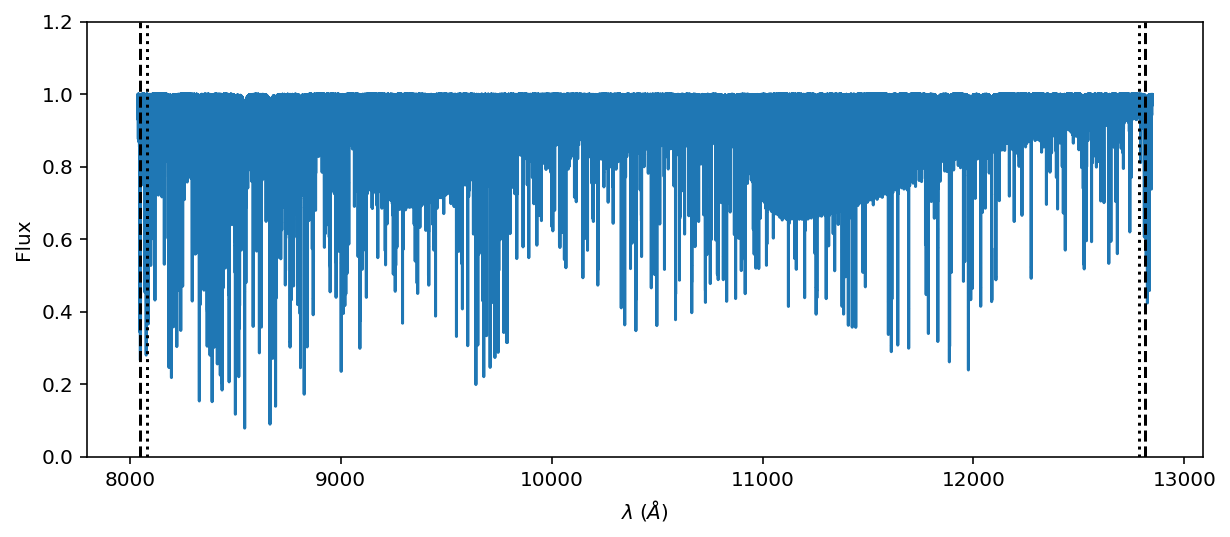

In [6]:
ax = spectrum.plot(ylo=0);
ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k');

In [7]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [8]:
emulator = SparsePhoenixEmulator(wl_native, flux_native, prominence=0.01)

Initializing a sparse model with 9028 spectral lines


In [9]:
emulator.to(device)

SparsePhoenixEmulator()

In [10]:
state_dict_init = emulator.state_dict()

In [11]:
state_dict_init['lam_centers'].shape

torch.Size([9028])

In [12]:
state_dict_post = torch.load('../examples/sparse_T4700g4p5_prom0p01_HPF.pt')

In [13]:
emulator.load_state_dict(state_dict_post)

<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    spec_out = emulator.forward().cpu().numpy()

CPU times: user 1.53 s, sys: 981 ms, total: 2.52 s
Wall time: 466 ms


## Read in real data

In [15]:
from muler.hpf import HPFSpectrum

In [16]:
! ls ../test

__pycache__        test_emulator.py   test_telluric.py
test_datasets.py   test_multiorder.py


In [17]:
raw_data = HPFSpectrum(file='/Users/mag3842/GitHub/muler_example_data/HPF/01_A0V_standards/Goldilocks_20210517T054403_v1.0_0060.spectra.fits', order=4)

In [18]:
data = raw_data.sky_subtract().deblaze().normalize().trim_edges((8,2040))

In [19]:
wl = emulator.wl_native[emulator.active_mask].numpy()
flux = emulator.flux_native[emulator.active_mask].numpy()

In [20]:
from blase.emulator import EchelleModel

In [21]:
model = EchelleModel(data.wavelength.value, pretrained_emulator=emulator)

In [22]:
model.to(device)

EchelleModel(
  (emulator): SparsePhoenixEmulator()
)

In [23]:
%%time
with torch.no_grad():
    output = model.forward()[emulator.active_mask.cpu().numpy()]

CPU times: user 2.83 s, sys: 2.09 s, total: 4.92 s
Wall time: 1.1 s


In [24]:
data.wavelength.value

array([8534.80423111, 8534.86694689, 8534.92965486, ..., 8644.12083933,
       8644.16542381, 8644.20999867])

In [25]:
data.spectral_axis.bin_edges.value

array([8534.77287322, 8534.835589  , 8534.89830087, ..., 8644.14313157,
       8644.18771124, 8644.23228609])

Make a ragged array of masks: which model pixels fit into the much larger data pixels?

In [26]:
labels = np.searchsorted(data.spectral_axis.bin_edges.value, wl)

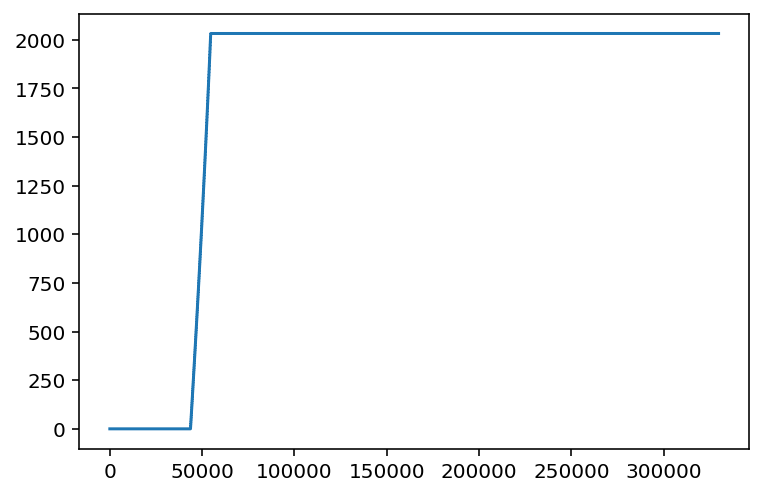

In [27]:
plt.plot(labels)

In [28]:
indices = torch.tensor(labels)

In [29]:
idx, vals = torch.unique(indices, return_counts=True)

In [30]:
vals

tensor([ 43676,      6,      6,  ...,      4,      5, 275025])

In [31]:
vs = torch.split_with_sizes(output, tuple(vals))

In [32]:
resampled_model_flux = torch.tensor([v.mean() for v in vs])

# Discard the first and last bins-- they're outside the beginning and end of the spectrum!
resampled_model_flux = resampled_model_flux[1:-1]

resampled_model_flux = resampled_model_flux/resampled_model_flux.mean()

In [33]:
data.wavelength.shape

(2031,)

In [34]:
resampled_model_flux.shape

torch.Size([2031])

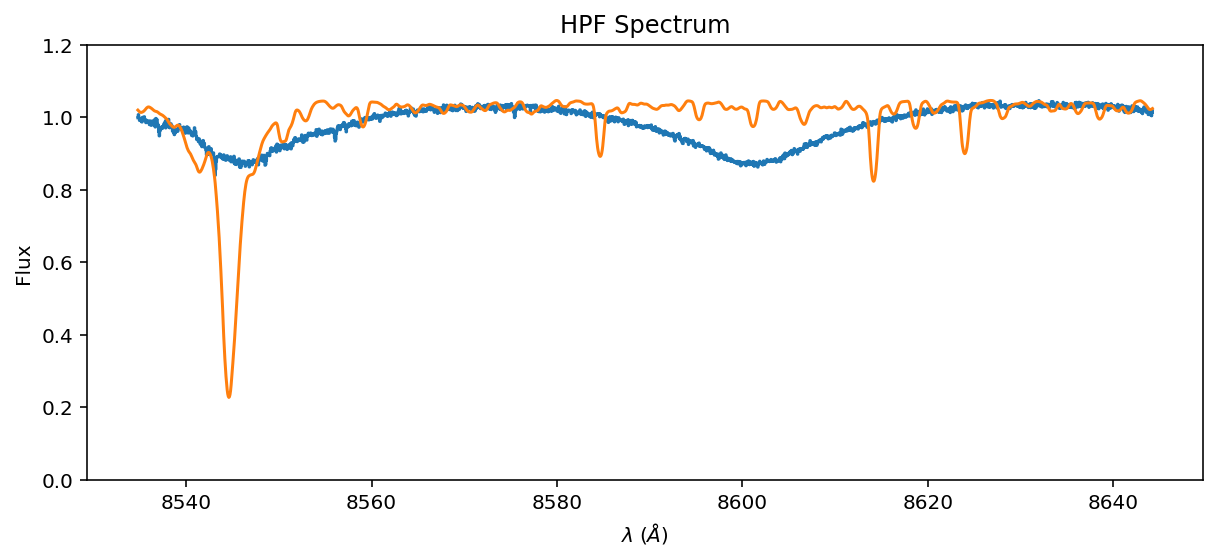

In [35]:
ax = data.plot(ylo=0);
ax.plot(data.wavelength, resampled_model_flux/resampled_model_flux.mean())

Yay! We have doctored the emulator model to work with real data and real astrophysical parameters!

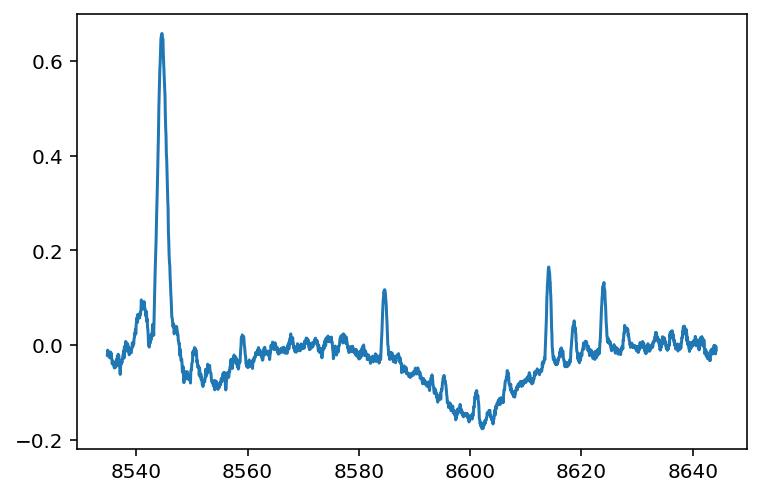

In [36]:
plt.plot(data.wavelength, data.flux.value - resampled_model_flux.cpu().numpy());

Awesome, I think we have an efficient way to RV shift, convolve, and bin the spectra!  Next step is running the neural network training!